In [1]:
%autosave 0
%matplotlib inline

import os, sys
sys.path.insert(0, os.path.expanduser('~/git/github/pymc-devs/pymc3'))

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import daft
import pymc3 as pm
import numpy as np
import seaborn as sns

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as display

Autosave disabled


<br />

<div style="text-align: center;">
<font size="7"><b>Introduction to </b></font>
<div style="display: inline-block; vertical-align: middle;">
<img src="./pymc3_logo.jpg" width=200 height=200 /></div> 
</div>
<br />
<br />
<br />
<br />
<div style="text-align: right;">
<font size="6">Taku Yoshioka</font>
</div>

<br />

# PyMC3
* Python library for Bayesian inference

    * Define probabilistic models consisting of random variables (RVs)
    * Draw samples of RVs from the posterior distribution with MCMC
    * Fit parametrized approximate posterior to data with variational inference
    
## Examples in this notebook
* Borrowed from Thomas Wiecki's notebook ([here](https://github.com/twiecki/pymc3_talk/blob/master/bayesian_pymc3.ipynb)). 

# Probabilistic model
* Decomposition of the joint probability of all random variables (RVs)

$$
p(x,z) = p(x|z)p(z)
$$
* $p(x,z)$: joint distribution of $x$ and $z$
* $p(z)$: prior distribution on $z$
* $p(x|z)$: likelihood of data $x$ given $z$

# Probabilistic graphical model
* Graphical representation of the probabilistic model

$$
p(x,z) = p(x|z)p(z)
$$

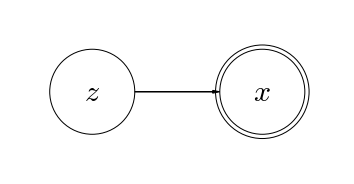

In [37]:
rc('font', size=30)
pgm = daft.PGM([6, 3], observed_style="outer") #, aspect=3.2)
pgm.add_node(daft.Node("z", r"$z$", 1.5, 1.5, scale=3.0))
pgm.add_node(daft.Node("x", r"$x$", 4.5, 1.5, observed=True, scale=3.0))
pgm.add_edge("z", "x")
pgm.render(); #.figure.savefig("fixed.png", dpi=150)
plt.show()

# Bayesian inference
* Infer the posterior distribution $p(z|x)$, the distribution of the unkown RVs $z$ given observations $x$ (which is also RVs), based on the Bayes theorem:

$$
p(z|x) = \frac{p(x,z)}{p(x)}=\frac{p(x|z)p(z)}{p(x)}
$$

# Chain rule
* Used for hierarchical models
\begin{eqnarray}
p(x,z_{1},z_{2}) = p(x|z_{1})p(z_{1}|z_{2})p(z_{2}) & & {\rm (model)} \\
p(z_{1},z_{2}|x) = \frac{p(x,z_{1},z_{2})}{p(x)} & \hspace{1.0cm} & {\rm (inference)}
\end{eqnarray}

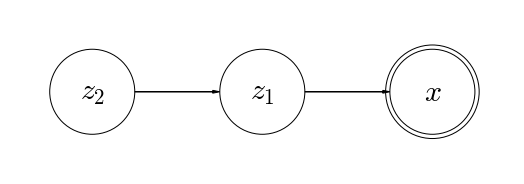

In [7]:
rc('font', size=30)
pgm = daft.PGM([9, 3], observed_style="outer") #, aspect=3.2)
pgm.add_node(daft.Node("z2", r"$z_{2}$", 1.5, 1.5, scale=3.0))
pgm.add_node(daft.Node("z1", r"$z_{1}$", 4.5, 1.5, scale=3.0))
pgm.add_node(daft.Node("x", r"$x$", 7.5, 1.5, observed=True, scale=3.0))
pgm.add_edge("z2", "z1")
pgm.add_edge("z1", "x")
pgm.render(); #.figure.savefig("fixed.png", dpi=150)
plt.show()

# Example 1: linear regression
$$
p(y_{i}|x_{i},\beta,\sigma) = N(y_{i}|\mu_{i}=\alpha + \beta x_{i},\sigma)p(\beta)p(\sigma)
$$

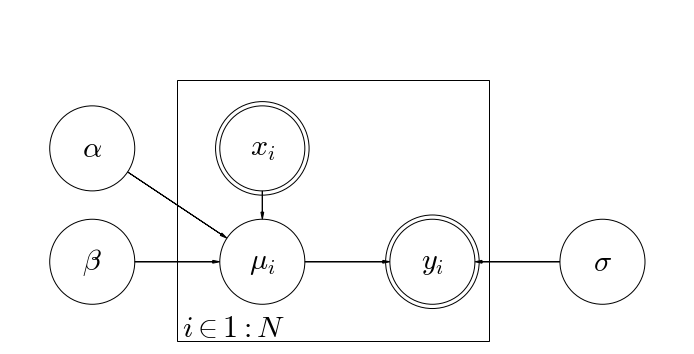

In [4]:
rc('font', size=30)
pgm = daft.PGM([12, 6], observed_style="outer") #, aspect=3.2)
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1.5, 3.5, scale=3.0))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 1.5, scale=3.0))
pgm.add_node(daft.Node("mu", r"$\mu_{i}$", 4.5, 1.5, scale=3.0))
pgm.add_node(daft.Node("y", r"$y_{i}$", 7.5, 1.5, scale=3.0, observed=True))
pgm.add_node(daft.Node("x", r"$x_{i}$", 4.5, 3.5, scale=3.0, observed=True))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 10.5, 1.5, scale=3.0))
pgm.add_edge("alpha", "mu")
pgm.add_edge("beta", "mu")
pgm.add_edge("x", "mu")
pgm.add_edge("mu", "y")
pgm.add_edge("sigma", "y")
pgm.add_plate(daft.Plate([3.0, 0.2, 5.5, 4.5], label=r"$i \in 1:N$", 
                         shift=-0.1))
pgm.render(); #.figure.savefig("fixed.png", dpi=150)
plt.show()

# Generate artificial data

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

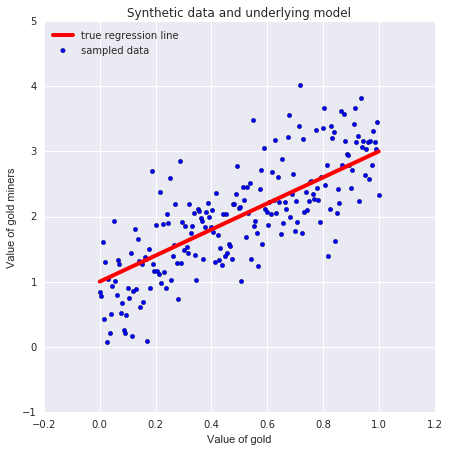

In [16]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='Value of gold', ylabel='Value of gold miners', title='Synthetic data and underlying model')
plt.scatter(x, y, label='sampled data')
plt.plot(x, true_regression_line, label='true regression line', linewidth=4., color='red')
ax.legend(loc=2);

# Bayesian inference with PyMC3
* Define probabilistic model
* Inference: draw samples of RVs from the posterior distribution

## Define model

In [8]:
import pymc3 as pm

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    # Define linear regression
    y_est = alpha + beta * x
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

## Inference

In [ ]:
with model:
    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(state=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, start=start, progressbar=False) # draw 2000 posterior samples using NUTS sampling

# Posterior distribution of parameters

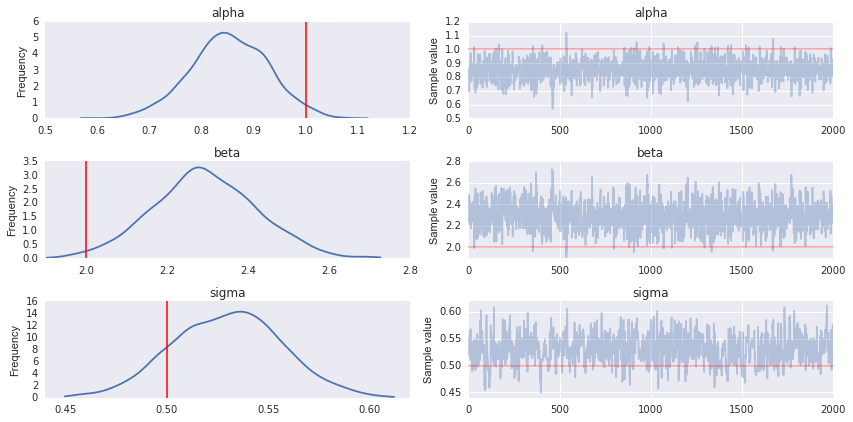

In [9]:
pm.traceplot(trace, lines={'alpha': 1, 'beta': 2, 'sigma': .5});

# Posterior distribution of regression line

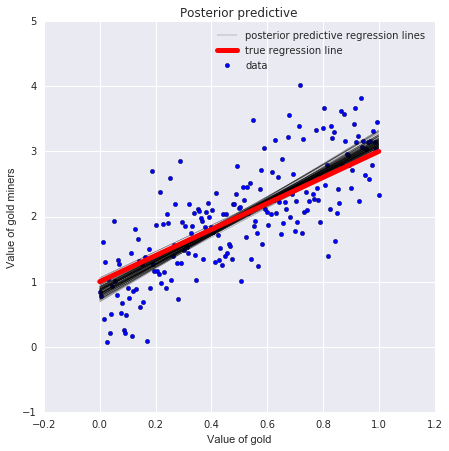

In [17]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='Value of gold', ylabel='Value of gold miners', title='Posterior predictive regression lines')
plt.scatter(x, y, label='data')
from pymc3 import glm
glm.plot_posterior_predictive(trace, samples=100, lm=lambda x, sample: sample['alpha'] + sample['beta'] * x, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', linewidth=5., color='red')
ax.legend(loc=0);

# Example 2: Algorithmic Trading
* Pairtrading is a famous technique that plays two stocks against each other.
* For this to work, stocks must be correlated (cointegrated).
* One common example is the price of gold (GLD) and the price of gold mining operations (GDX).

In [19]:
import zipline
import pytz
from datetime import datetime
fig = plt.figure(figsize=(8, 4))

prices = zipline.data.load_from_yahoo(stocks=['GLD', 'GDX'], 
                                 end=datetime(2013, 8, 1, 0, 0, 0, 0, pytz.utc)).dropna()[:1000];

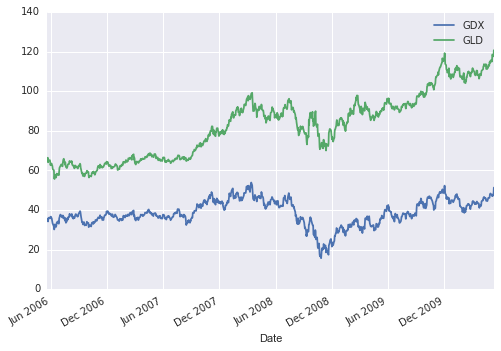

In [20]:
prices.plot();

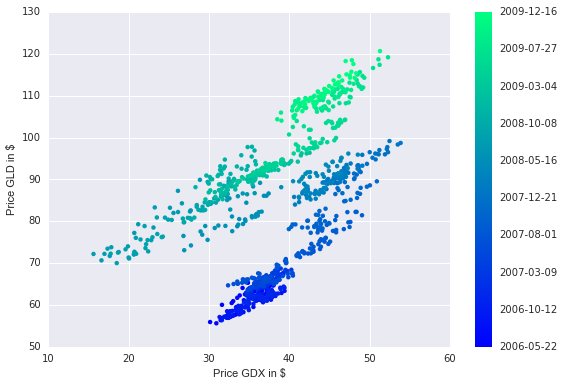

In [21]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GDX in \$', ylabel='Price GLD in \$')
colors = np.linspace(0.1, 1, len(prices))
mymap = plt.get_cmap("winter")
sc = ax.scatter(prices.GDX, prices.GLD, c=colors, cmap=mymap, lw=0)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);

# Static model
* Model parameters ($\alpha$ and $\beta$) doesn't change over time (same with the above examples)
![naive_regression](naive_regression)

# Hierarchical dynamic model
* Model parameters change over time (subscript $i$)
* Put randomwalk priors on $\alpha_{i}$ and $\beta_{i}$, which depend on $\alpha_{i-1}$, $\beta_{i-1}$

    * Temporal *constraint* on model parameters

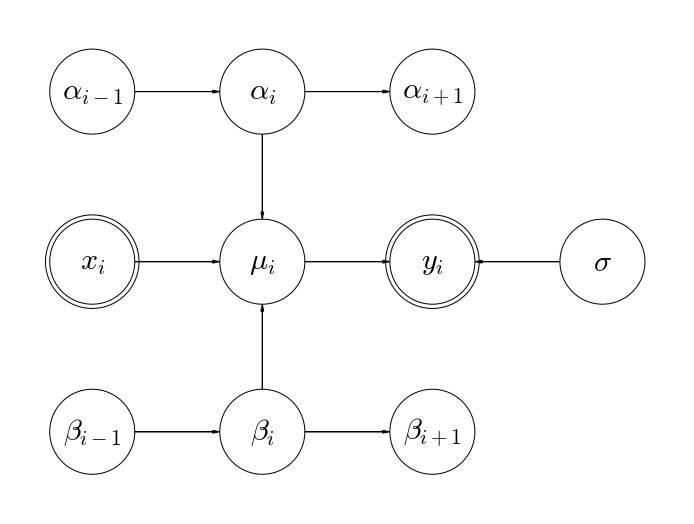

In [60]:
rc('font', size=30)
pgm = daft.PGM([12, 9], observed_style="outer") #, aspect=3.2)
pgm.add_node(daft.Node("alpha_i-1", r"$\alpha_{i-1}$", 1.5, 7.5, scale=3.0))
pgm.add_node(daft.Node("alpha_i", r"$\alpha_{i}$", 4.5, 7.5, scale=3.0))
pgm.add_node(daft.Node("alpha_i+1", r"$\alpha_{i+1}$", 7.5, 7.5, scale=3.0))
pgm.add_edge("alpha_i-1", "alpha_i")
pgm.add_edge("alpha_i", "alpha_i+1")

pgm.add_node(daft.Node("beta_i-1", r"$\beta_{i-1}$", 1.5, 1.5, scale=3.0))
pgm.add_node(daft.Node("beta_i", r"$\beta_{i}$", 4.5, 1.5, scale=3.0))
pgm.add_node(daft.Node("beta_i+1", r"$\beta_{i+1}$", 7.5, 1.5, scale=3.0))
pgm.add_edge("beta_i-1", "beta_i")
pgm.add_edge("beta_i", "beta_i+1")

pgm.add_node(daft.Node("mu_i", r"$\mu_{i}$", 4.5, 4.5, scale=3.0))
pgm.add_edge("alpha_i", "mu_i")
pgm.add_edge("beta_i", "mu_i")

pgm.add_node(daft.Node("x_i", r"$x_{i}$", 1.5, 4.5, scale=3.0, observed=True))
pgm.add_edge("x_i", "mu_i")

pgm.add_node(daft.Node("y_i", r"$y_{i}$", 7.5, 4.5, scale=3.0, observed=True))
pgm.add_edge("mu_i", "y_i")

pgm.add_node(daft.Node("sigma", r"$\sigma$", 10.5, 4.5, scale=3.0))
pgm.add_edge("sigma", "y_i")



pgm.render(); #.figure.savefig("fixed.png", dpi=150)
plt.show()

## Define model 1/1: parameters following random walk

In [33]:
from pymc3.distributions.timeseries import *
from theano.tensor import repeat

# To make the model simpler, we will apply the same coefficient for 50 data points at a time
subsample_alpha = 50
subsample_beta = 50

with pm.Model() as model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 1./.02, testval=.1)
    sigma_beta = pm.Exponential('sigma_beta', 1./.02, testval=.1)
    
    alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, 
                               shape=int(len(prices) / subsample_alpha))
    beta = GaussianRandomWalk('beta', sigma_beta**-2, 
                              shape=int(len(prices) / subsample_beta))
    
    # Make coefficients have the same length as prices
    alpha_r = repeat(alpha, subsample_alpha)
    beta_r = repeat(beta, subsample_beta)  

## Define model 1/2: likelihood

In [34]:
with model_randomwalk:
    # Define regression
    regression = alpha_r + beta_r * prices.GDX.values
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sd=sd, 
                           observed=prices.GLD.values)

## Inference

In [35]:
from scipy import optimize
with model_randomwalk:
    # First optimize random walk
    start = pm.find_MAP(vars=[alpha, beta], fmin=optimize.fmin_l_bfgs_b)
    
    # Sample
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(2000, step, start=start, progressbar=False)

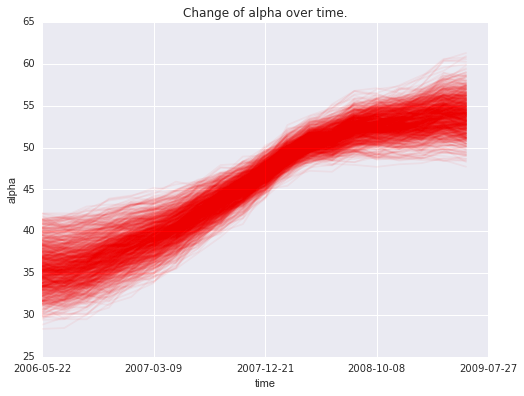

In [38]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='alpha', title='Change of alpha over time.')
plt.plot(trace_rw[-1000:][alpha].T, 'r', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

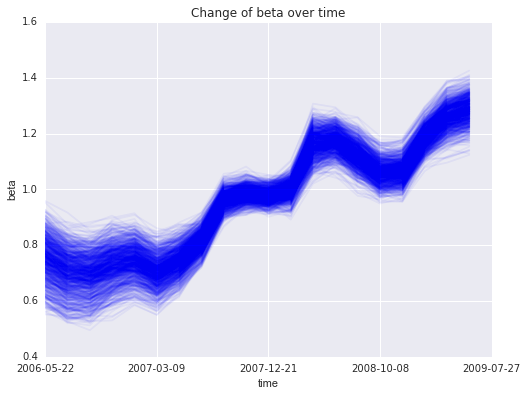

In [39]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='time', ylabel='beta', title='Change of beta over time')
plt.plot(trace_rw[-1000:][beta].T, 'b', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

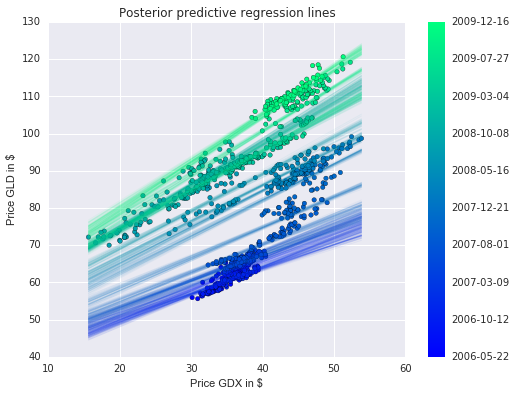

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='Price GDX in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[-500::10]['alpha'].T))
mymap = plt.get_cmap('winter')
mymap_sc = plt.get_cmap('winter')

xi = np.linspace(prices.GDX.min(), prices.GDX.max(), 50)
for i, (alpha, beta) in enumerate(zip(trace_rw[-500::10]['alpha'].T, trace_rw[-500::10]['beta'].T)):
    for a, b in zip(alpha, beta):
        ax.plot(xi, a + b*xi, alpha=.05, lw=1, c=mymap_sc(colors_sc[i]))
        
sc = ax.scatter(prices.GDX, prices.GLD, label='data', cmap=mymap, c=colors)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);

# Summary
* PyMC3 allows us to define probabilistic models
* Don't need to write code for inference, just invoking a function
* Easy to write complex structure on RVs

    * Hierarchical models can impose constraints on RVs as prior distribution